## Eigen-portfolio construction using Principal Component Analysis (PCA)

### PCA via sklearn.decomposition using S&P 500 Index stock data

In [1]:
import os
import os.path
import numpy as np
import pandas as pd
import datetime

import sys
sys.path.append("..")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load dataset
asset_prices = pd.read_csv('spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :20].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AGN,AIG,AIV,AKAM,AKS,ALL
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625,37.9375,20.5938,39.688,1175.5873,26.8393,281.1250,10.8125,23.1875
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000,38.1875,21.0000,40.250,1139.2866,26.8393,270.0625,11.0000,22.8125
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000,40.0625,21.7188,40.313,1165.8141,26.9281,249.1250,10.1250,23.1875
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875,40.3750,22.1563,41.375,1143.4751,26.9726,239.0625,9.9375,23.0625
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250,39.6563,22.1875,42.813,1142.7770,26.9281,233.6250,10.0000,23.3125


In [3]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -10:].head()

Last column contains SPX index prices:


,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


#### Part 1 (Asset Returns Calculation)

Compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation.

In [4]:
asset_returns = pd.DataFrame(data=np.zeros(shape=(len(asset_prices.index), asset_prices.shape[1])), 
                             columns=asset_prices.columns.values,
                             index=asset_prices.index)
normed_returns = asset_returns

asset_returns = pd.DataFrame((asset_prices.iloc[1:,:].values-asset_prices.iloc[:-1,:].values)/asset_prices.iloc[:-1,:].values,
                             columns=asset_prices.columns.values,
                             index = asset_prices.index[1:])
normed_returns = (asset_returns - asset_returns.mean(axis = 0))/asset_returns.std(axis = 0)

normed_returns.head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-28,-0.190054,-0.513710,-2.714709,-0.049779,2.182933,-2.684131,-0.212461,-0.766996,-1.540731,-1.803947,...,-1.280756,-1.690468,1.853435,-1.032223,-2.354104,-0.735242,0.619711,-0.873112,-0.652514,-2.098603
2000-01-31,-0.898232,0.096888,0.688156,-1.757230,1.355644,-1.438899,-0.720771,-0.279098,-1.891884,-0.391433,...,0.845295,1.631244,1.457667,-0.877804,0.828987,0.498547,-0.789312,-0.824893,0.333856,1.903871
2000-02-01,2.319164,1.264327,-1.227995,1.539597,0.588289,0.451774,1.606541,0.975244,0.948126,1.272129,...,-1.166142,-1.334823,0.939094,0.473545,2.346267,0.258770,-0.093661,-0.018944,1.228056,0.795259
2000-02-02,2.471738,1.221529,-0.548494,0.464060,0.339454,3.133764,-0.616815,-1.012898,-3.348109,0.177340,...,-0.681225,-0.635746,-0.322437,0.131399,0.642124,0.719436,0.944422,-0.094098,-0.726004,-0.020920
2000-02-03,0.510174,-1.122380,1.551619,-0.388563,0.336944,4.078966,3.310577,-0.029293,4.090396,1.217955,...,1.248858,-0.392056,-0.324442,0.974903,1.334599,0.219252,-0.632596,-0.471922,1.124028,0.842399


In [5]:
train_end = datetime.datetime(2012, 3, 26) 

df_train = None
df_test = None
df_raw_train = None
df_raw_test = None

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 419)
Test dataset: (437, 419)


#### Part 2 (PCA fitting)

- Calculate covariance matrix using training data set, i.e. **df_train** for all assets.  Assign results to **cov_matrix**.
- Calculate covariance matrix using training data set, i.e. **df_raw_train** for all assets.  Assign results to **cov_matrix_raw**.
- Use scikit-learn PCA to fit PCA model to **cov_matrix**. Assign fitted model to **pca**

In [6]:
import sklearn.decomposition

In [7]:
stock_tickers = normed_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"
stock_tickers[:20]

array(['A', 'AA', 'AAPL', 'ABC', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP',
       'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AGN', 'AIG', 'AIV', 'AKAM',
       'AKS', 'ALL'], dtype=object)

In [8]:
n_tickers = len(stock_tickers)
pca = None
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_matrix_raw = cov_matrix

In [9]:
if df_train is not None and df_raw_train is not None:
    stock_tickers = asset_returns.columns.values[:-1]
    assert 'SPX' not in stock_tickers, "By accident included SPX index"
 
    cov_matrix = df_train[stock_tickers].cov()
    cov_matrix_raw = df_raw_train[stock_tickers].cov()
    pca = sklearn.decomposition.PCA().fit(cov_matrix)
    cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
    print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

4 components explain 80.00% of variance


In [10]:
np.diag(cov_matrix[: 100])

array([1.10446611, 1.09424087, 1.08190134, 1.10517006, 1.06941473,
       1.10597862, 1.11869287, 1.0839399 , 1.09803084, 1.06590728,
       1.07798702, 1.107393  , 1.12418337, 1.10412774, 1.07721126,
       1.11952577, 1.11507312, 1.10687469, 1.04827028, 1.10800935,
       1.10480045, 1.04297489, 1.07466613, 1.12510255, 1.10831513,
       1.09118222, 1.08418296, 1.02668336, 1.09808835, 1.08506552,
       1.08022595, 1.08116796, 1.09591114, 0.99807688, 1.11068716,
       1.01433366, 1.10360906, 1.06598755, 1.11003861, 1.0879927 ,
       1.08236593, 1.093903  , 1.08489115, 1.1050359 , 0.99850151,
       1.08347058, 1.1019318 , 1.08932552, 1.08876911, 1.09560839,
       1.1027858 , 1.09150807, 1.07067427, 1.1119615 , 1.07304668,
       1.10625388, 1.10454709, 1.11531806, 1.06707655, 1.08925028,
       1.07207857, 1.08151718, 1.11539438, 1.09563297, 1.09915349,
       1.10098573, 1.09770417, 1.05315411, 1.08235287, 1.10420203,
       1.10765821, 1.08524638, 1.02531398, 1.10595498, 1.10337

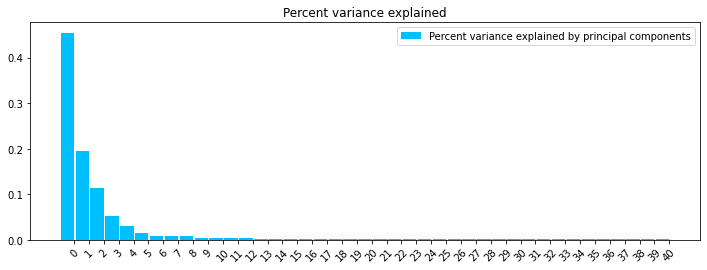

In [11]:
if pca is not None:
    bar_width = 0.9
    n_asset = int((1 / 10) * normed_returns.shape[1])
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.set_title('Percent variance explained')
    ax.legend((rects[0],), ('Percent variance explained by principal components',))

In [12]:
if pca is not None:
    projected = pca.fit_transform(cov_matrix)

#### Part 3 (Eigen-portfolios construction)

Definition of eigen portfolios as provided by Avellaneda 
http://math.nyu.edu/faculty/avellane/AvellanedaLeeStatArb20090616.pdf

Following Avellaneda eigen portfolio weights are defined as:
$$Q_i^{(j)} = \frac{v_i^{(j)}}{\sigma_i}$$

where $j$ is the index of eigen portfolio and $v_i$ is the i-th element of j-th eigen vector.

In [13]:
# the first four eigen-portfolio weights

pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
eigen_prtf3 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
eigen_prtf4 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)

if pca is not None:
    pcs = pca.components_
    # normalized to 1 
    pc_w1 = pcs[:,0]/np.sum(pcs[:,0])
    pc_w2 = pcs[:,1]/np.sum(pcs[:,1])
    pc_w3 = pcs[:,2]/np.sum(pcs[:,2])
    pc_w4 = pcs[:,3]/np.sum(pcs[:,3])
    
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w1.squeeze()*100}, index = stock_tickers)
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w2.squeeze()*100}, index = stock_tickers)
eigen_prtf3 = pd.DataFrame(data ={'weights': pc_w3.squeeze()*100}, index = stock_tickers)
eigen_prtf4 = pd.DataFrame(data ={'weights': pc_w4.squeeze()*100}, index = stock_tickers)
    
eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
eigen_prtf3.sort_values(by=['weights'], ascending=False, inplace=True)
eigen_prtf4.sort_values(by=['weights'], ascending=False, inplace=True)

print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf1))   
print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf3))    
print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf4))    

Sum of weights of second eigen-portfolio: 100.00
Sum of weights of second eigen-portfolio: 100.00
Sum of weights of second eigen-portfolio: 100.00
Sum of weights of second eigen-portfolio: 100.00


<AxesSubplot:title={'center':'First four eigen-portfolios weights'}>

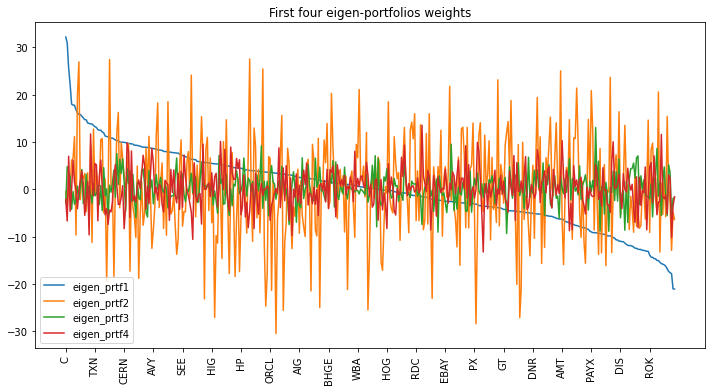

In [14]:
data_frames = [eigen_prtf1, eigen_prtf2,eigen_prtf3, eigen_prtf4]
df_merge = pd.concat(data_frames, join='outer', axis=1)
df_merge.columns = ["eigen_prtf1", "eigen_prtf2","eigen_prtf3", "eigen_prtf4"]

df_merge.plot(title='First four eigen-portfolios weights', 
                     figsize=(12,6),
                     xticks=range(0, len(stock_tickers),20),
                     rot=90)

#### Part 4 (Compute performance of several eigen portfolios)

- Returns annualized return, annualized vol, and annualized sharpe ratio, where sharpe ratio is defined as annualized return divided by annualized volatility 
- find portfolio (an index into sharpe_metric) that has the highest sharpe ratio

In [15]:
def sharpe_ratio(ts_returns, periods_per_year=252):    
    annualized_return = .0
    annualized_vol = .0
    annualized_sharpe = .0

    n = len(ts_returns)/periods_per_year
    annualized_return = np.prod(1+ts_returns)**(1/n)-1
    annualized_vol = ts_returns.std()* np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return/annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

First eigen-portfolio:
Return = 41.39%
Volatility = 31.50%
Sharpe = 1.31


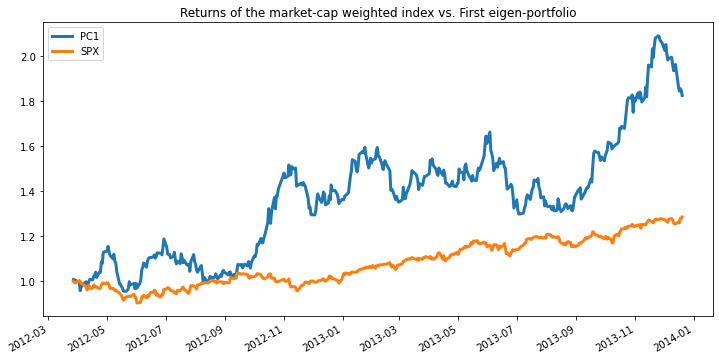

In [16]:
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

Second eigen-portfolio:
Return = 15.76%
Volatility = 42.84%
Sharpe = 0.37


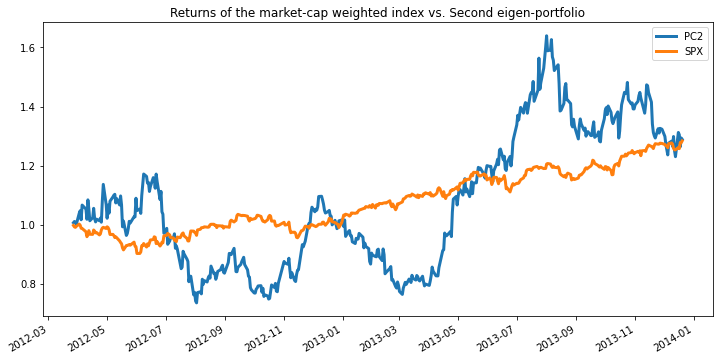

In [17]:
if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf2_returns.index[-1] - eigen_prtf2_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC2': eigen_prtf2_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. Second eigen-portfolio', 
                             figsize=(12,6), linewidth=3) 

<ipython-input-15-b4155f8e424c>:7: RuntimeWarning: invalid value encountered in double_scalars
  annualized_return = np.prod(1+ts_returns)**(1/n)-1


Eigen portfolio #42 with the highest Sharpe. Return 61.14%, vol = 22.80%, Sharpe = 2.68


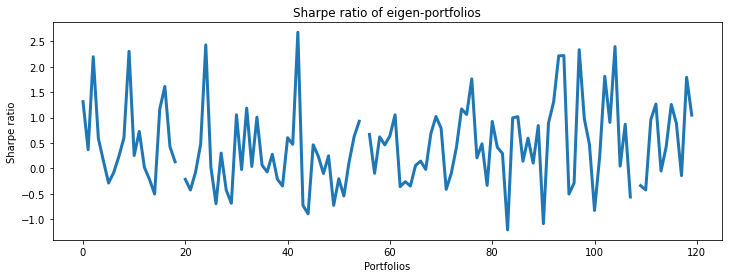

In [18]:
n_portfolios = 120
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0 # index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio
    
if pca is not None:
    for ix in range(n_portfolios):
        pcs = pca.components_
        pc_w = pcs[:,ix]/np.sum(pcs[:,ix])
        ts_returns = pd.Series(np.dot(df_raw_test.loc[:, stock_tickers], pc_w))
        annualized_ret[ix], annualized_vol[ix], sharpe_metric[ix] = sharpe_ratio(ts_returns, periods_per_year=252)
    
    # find portfolio with the highest Sharpe ratio
    for ix in range(n_portfolios):
        if sharpe_metric[ix] > sharpe_metric[idx_highest_sharpe]:
            idx_highest_sharpe = ix
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (idx_highest_sharpe,
           annualized_ret[idx_highest_sharpe]*100, 
           annualized_vol[idx_highest_sharpe]*100, 
           sharpe_metric[idx_highest_sharpe]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

In [19]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.dropna(inplace = True)
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
results.head(10)

,Return,Vol,Sharpe
42,0.611437,0.228033,2.681354
24,1.032178,0.424530,2.431344
104,0.512464,0.213640,2.398724
97,1.425562,0.609754,2.337929
9,0.753548,0.326692,2.306601
94,0.502025,0.225976,2.221589
93,0.601081,0.271151,2.216774
2,0.453437,0.206247,2.198512
102,0.274142,0.151208,1.813008
118,0.874381,0.487549,1.793422


In [20]:
idx_highest_sharpe

42